# 필요 라이브러리 import

In [1]:
from google.colab import drive
import zipfile
import os
import random
from IPython.display import Image as show_image
import matplotlib.pyplot as plt
import json
import glob
import numpy as np
import pandas as pd
from ast import literal_eval
from PIL import Image, ImageDraw
from tqdm import tqdm
import yaml
from collections import OrderedDict
import shutil
import torch

# 드라이브 마운트 후 압축 해제

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 파일 경로 설정
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/Mini Project/Cat breeds detection/V_2/Cat Breeds Detection_v2.v1i.yolov11.zip'
extract_path = '/content/'

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"압축 해제 완료: {zip_file_path} -> {extract_path}")
except FileNotFoundError:
    print(f"파일을 찾을 수 없습니다: {zip_file_path}")
except zipfile.BadZipFile:
    print(f"잘못된 zip 파일입니다: {zip_file_path}")
except Exception as e:
    print(f"압축 해제 중 오류 발생: {e}")

압축 해제 완료: /content/drive/MyDrive/Colab Notebooks/Mini Project/Cat breeds detection/V_2/Cat Breeds Detection_v2.v1i.yolov11.zip -> /content/


train 폴더의 이미지 개수: 1119


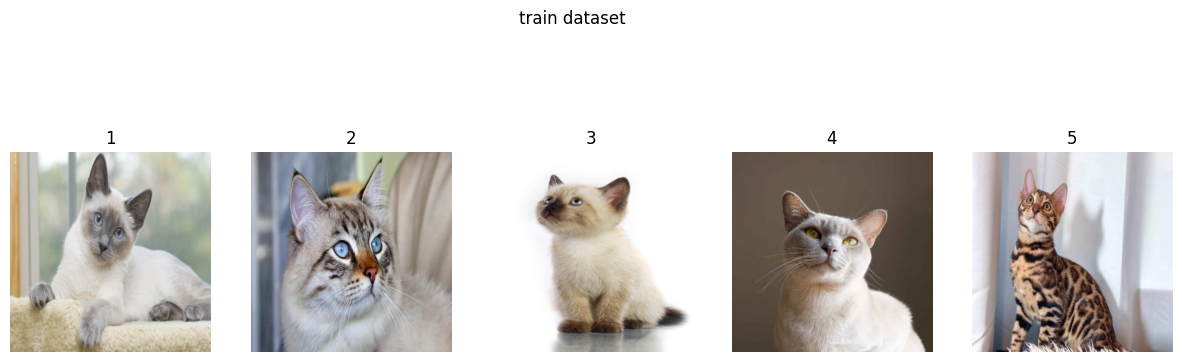

In [4]:
# 이미지 폴더 경로 설정
base_path = '/content/'
folders = ['train']

for folder in folders:
    image_folder = os.path.join(base_path, folder, 'images')
    if not os.path.exists(image_folder):
        print(f"폴더가 존재하지 않습니다: {image_folder}")
        continue

    image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
    num_images = len(image_files)
    print(f"{folder} 폴더의 이미지 개수: {num_images}")

    # 랜덤으로 5개 이미지 선택 (중복 없이)
    selected_images = random.sample(image_files, min(5, num_images))

    # 폴더별 5장의 이미지 시각화 (이미지 이름 대신 번호 사용)
    plt.figure(figsize=(15, 5))
    for i, image_file in enumerate(selected_images):
        img_path = os.path.join(image_folder, image_file)
        try:
            img = Image.open(img_path)
            plt.subplot(1, 5, i + 1)
            plt.imshow(img)
            plt.title(f"{i+1}")  # 이미지 번호 표시
            plt.axis('off')
        except Exception as e:
            print(f"이미지 로드 중 오류 발생: {e}, 파일: {img_path}")

    plt.suptitle(f"{folder} dataset")
    plt.show()

---

### YOLO 설치

In [5]:
!pip3 install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 902.2/902.2 kB 19.5 MB/s eta 0:00:00


In [6]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.8/112.6 GB disk)


In [7]:
model = YOLO('yolo11s.pt')

100%|██████████| 18.4M/18.4M [00:00<00:00, 127MB/s] 


### 다운샘플링

In [8]:
from collections import defaultdict

def downsample_classes(label_dir, target_classes, target_count):
    # 클래스별 파일 인덱스 수집
    class_files = defaultdict(list)

    # 라벨 파일들을 순회하며 클래스별로 파일 수집
    for label_file in os.listdir(label_dir):
        file_path = os.path.join(label_dir, label_file)
        with open(file_path, 'r') as f:
            label = int(f.readline().split()[0])
            if label in target_classes:
                class_files[label].append(label_file)

    # 제거할 파일 선택
    files_to_remove = []
    for class_id in target_classes:
        if len(class_files[class_id]) > target_count:
            # 무작위로 파일 선택하여 유지할 개수만 남기기
            files_to_keep = random.sample(class_files[class_id], target_count)
            files_to_remove.extend([f for f in class_files[class_id] if f not in files_to_keep])

    # 선택된 파일들 제거
    for file_name in files_to_remove:
        # 라벨 파일 제거
        label_path = os.path.join(label_dir, file_name)
        if os.path.exists(label_path):
            os.remove(label_path)

        # 해당하는 이미지 파일도 제거
        image_file = file_name.replace('.txt', '.jpg')
        image_path = os.path.join('train/images', image_file)
        if os.path.exists(image_path):
            os.remove(image_path)

    return len(files_to_remove)

# 실행
target_classes = [7, 16, 19]
target_count = 80  # 각 클래스당 유지할 샘플 수
removed_count = downsample_classes('train/labels', target_classes, target_count)
print(f"제거된 파일 수: {removed_count}")

제거된 파일 수: 111


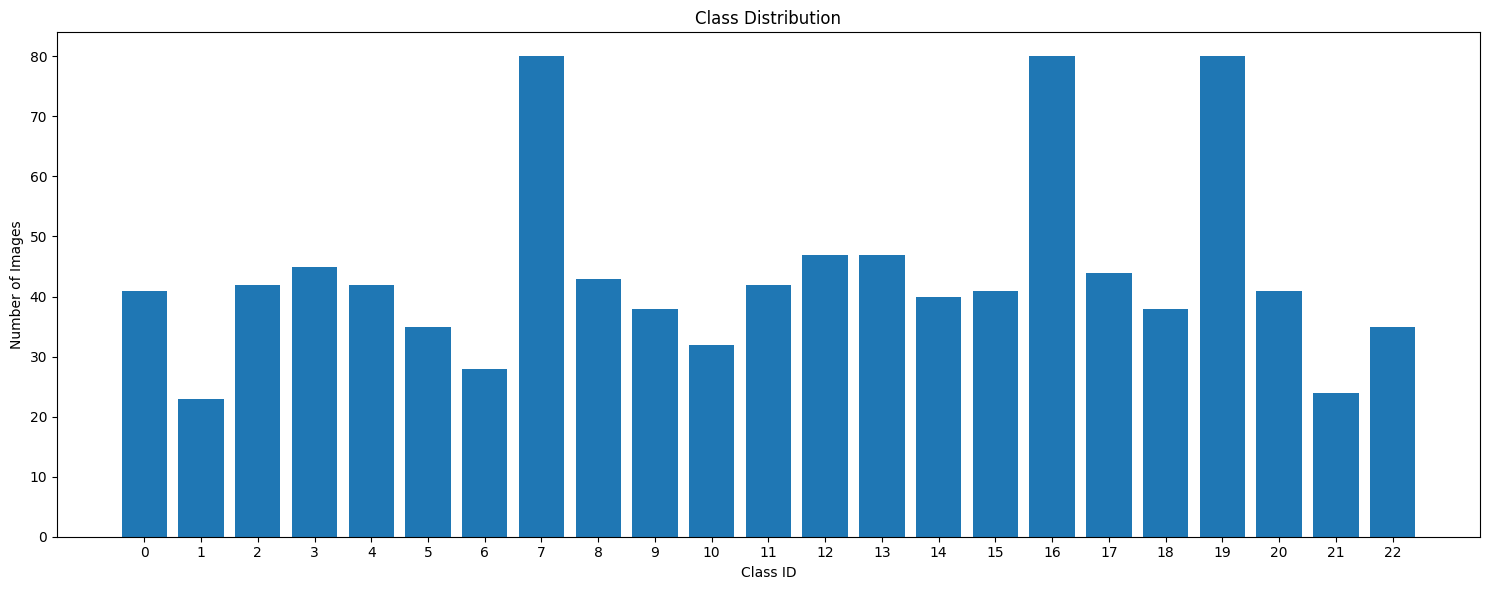

Class 14: 40 images
Class 19: 80 images
Class 2: 42 images
Class 7: 80 images
Class 6: 28 images
Class 22: 35 images
Class 16: 80 images
Class 9: 38 images
Class 10: 32 images
Class 11: 42 images
Class 13: 47 images
Class 17: 44 images
Class 3: 45 images
Class 18: 38 images
Class 20: 41 images
Class 12: 47 images
Class 5: 35 images
Class 4: 42 images
Class 8: 43 images
Class 0: 41 images
Class 1: 23 images
Class 15: 41 images
Class 21: 24 images


In [9]:
from collections import Counter

def visualize_class_distribution(label_dir):
    class_counts = Counter()

    # 라벨 파일들을 순회하며 클래스별 개수 계산
    for label_file in os.listdir(label_dir):
        file_path = os.path.join(label_dir, label_file)
        with open(file_path, 'r') as f:
            label = int(f.readline().split()[0])
            class_counts[label] += 1

    # 클래스 ID와 개수 추출
    classes = sorted(class_counts.keys())
    counts = [class_counts[c] for c in classes]

    # 시각화
    plt.figure(figsize=(15, 6))
    plt.bar(classes, counts)
    plt.title('Class Distribution')
    plt.xlabel('Class ID')
    plt.ylabel('Number of Images')
    plt.xticks(classes)
    plt.tight_layout()
    plt.show()

    # 클래스별 개수 출력
    for class_id, count in class_counts.items():
        print(f"Class {class_id}: {count} images")

# 실행
visualize_class_distribution('train/labels')


### 업샘플링

In [10]:
def upsample_classes(label_dir, target_classes, target_count):
    # 클래스별 파일 인덱스 수집
    class_files = defaultdict(list)

    # 라벨 파일들을 순회하며 클래스별로 파일 수집
    for label_file in os.listdir(label_dir):
        file_path = os.path.join(label_dir, label_file)
        with open(file_path, 'r') as f:
            label = int(f.readline().split()[0])
            if label in target_classes:
                class_files[label].append(label_file)

    # 업샘플링 수행
    files_added = 0
    for class_id in target_classes:
        current_files = class_files[class_id]
        samples_needed = target_count - len(current_files)

        if samples_needed > 0:
            # 무작위로 파일 선택하여 복제
            for i in range(samples_needed):
                # 원본 파일 선택
                original_file = random.choice(current_files)

                # 새 파일명 생성
                new_label_file = f"{os.path.splitext(original_file)[0]}_up{i}.txt"
                new_image_file = f"{os.path.splitext(original_file)[0]}_up{i}.jpg"

                # 라벨 파일 복사
                shutil.copy2(
                    os.path.join(label_dir, original_file),
                    os.path.join(label_dir, new_label_file)
                )

                # 이미지 파일 복사
                original_image = original_file.replace('.txt', '.jpg')
                shutil.copy2(
                    os.path.join('train/images', original_image),
                    os.path.join('train/images', new_image_file)
                )

                files_added += 1

    return files_added

# 실행
target_classes = [1, 5, 6, 10, 21, 22]
target_count = 40  # 각 클래스당 목표 샘플 수
added_count = upsample_classes('train/labels', target_classes, target_count)
print(f"추가된 파일 수: {added_count}")


추가된 파일 수: 63


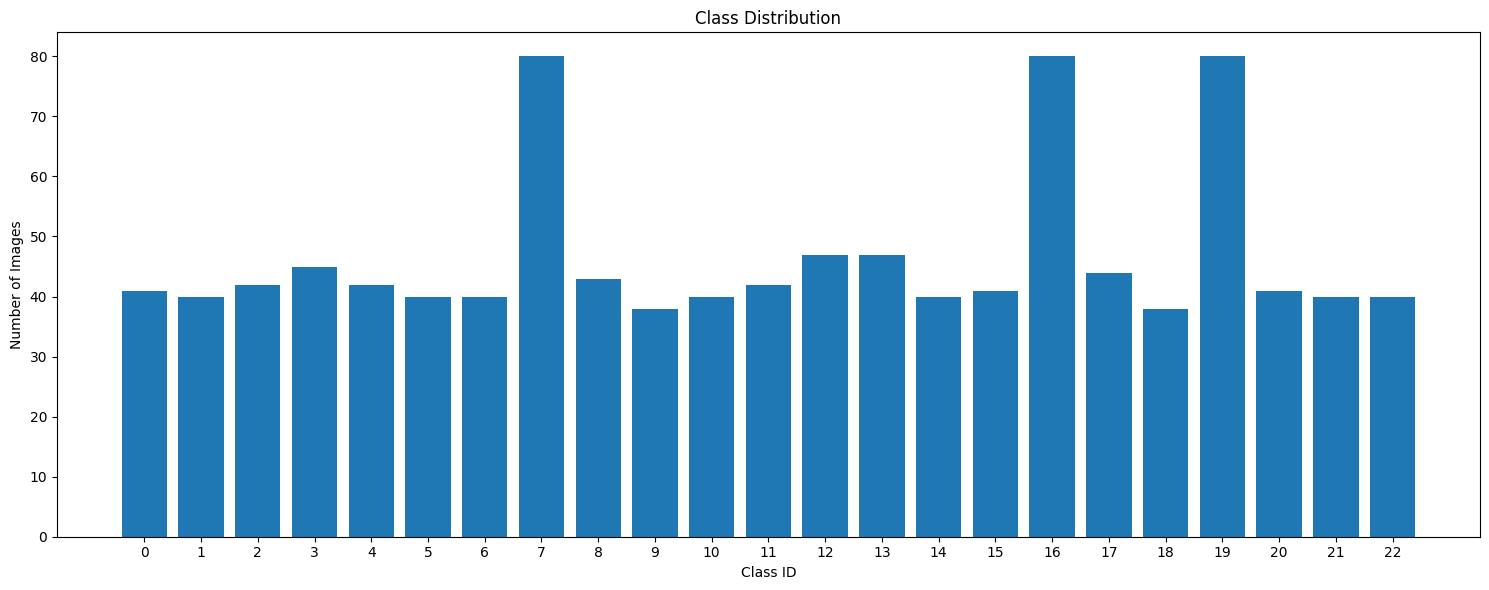

Class 14: 40 images
Class 19: 80 images
Class 2: 42 images
Class 7: 80 images
Class 6: 40 images
Class 22: 40 images
Class 16: 80 images
Class 9: 38 images
Class 10: 40 images
Class 11: 42 images
Class 13: 47 images
Class 17: 44 images
Class 3: 45 images
Class 18: 38 images
Class 20: 41 images
Class 12: 47 images
Class 5: 40 images
Class 4: 42 images
Class 8: 43 images
Class 0: 41 images
Class 1: 40 images
Class 15: 41 images
Class 21: 40 images


In [11]:
def visualize_class_distribution(label_dir):
    class_counts = Counter()

    # 라벨 파일들을 순회하며 클래스별 개수 계산
    for label_file in os.listdir(label_dir):
        file_path = os.path.join(label_dir, label_file)
        with open(file_path, 'r') as f:
            label = int(f.readline().split()[0])
            class_counts[label] += 1

    # 클래스 ID와 개수 추출
    classes = sorted(class_counts.keys())
    counts = [class_counts[c] for c in classes]

    # 시각화
    plt.figure(figsize=(15, 6))
    plt.bar(classes, counts)
    plt.title('Class Distribution')
    plt.xlabel('Class ID')
    plt.ylabel('Number of Images')
    plt.xticks(classes)
    plt.tight_layout()
    plt.show()

    # 클래스별 개수 출력
    for class_id, count in class_counts.items():
        print(f"Class {class_id}: {count} images")

# 실행
visualize_class_distribution('train/labels')


In [12]:
for folder in folders:
    image_folder = os.path.join(base_path, folder, 'images')
    if not os.path.exists(image_folder):
        print(f"폴더가 존재하지 않습니다: {image_folder}")
        continue

    image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
    num_images = len(image_files)
    print(f"{folder} 폴더의 이미지 개수: {num_images}")

train 폴더의 이미지 개수: 1071


---

### train / valid / test 분리

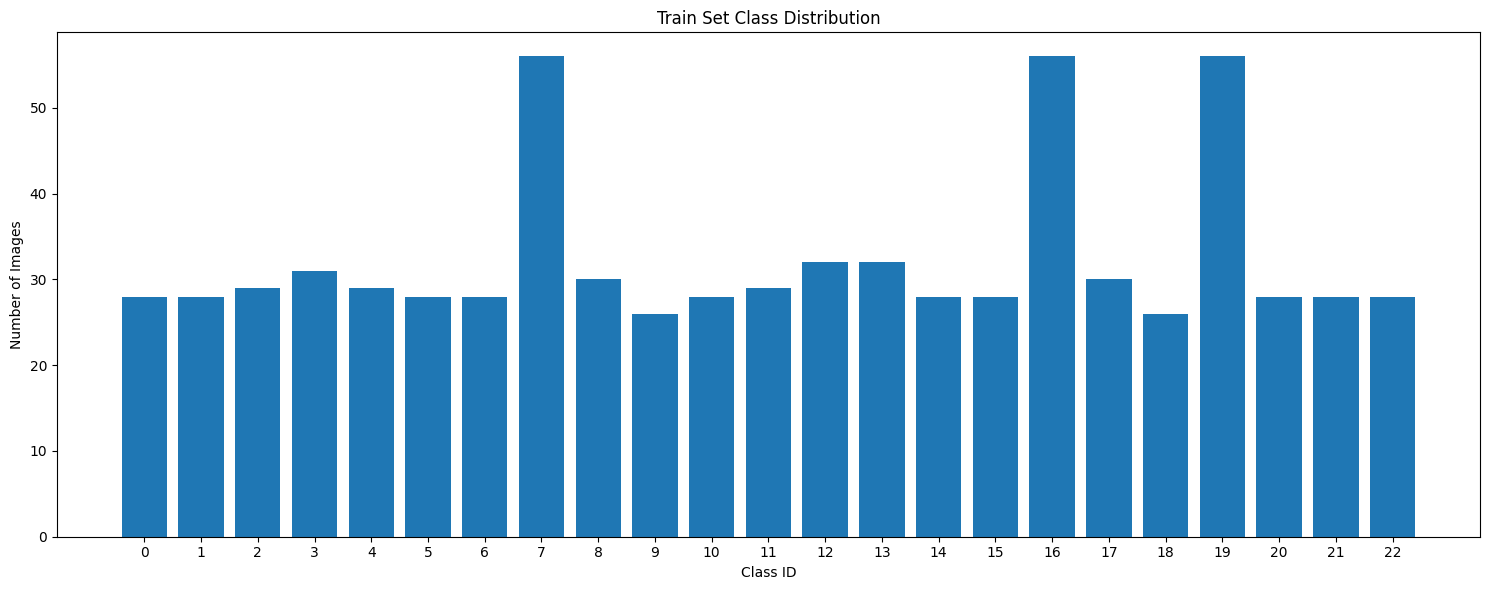


Train Set Statistics:
Total images: 742
Class distribution: {19: 56, 7: 56, 6: 28, 22: 28, 16: 56, 13: 32, 3: 31, 2: 29, 18: 26, 20: 28, 12: 32, 5: 28, 4: 29, 8: 30, 0: 28, 17: 30, 1: 28, 10: 28, 11: 29, 9: 26, 15: 28, 21: 28, 14: 28}


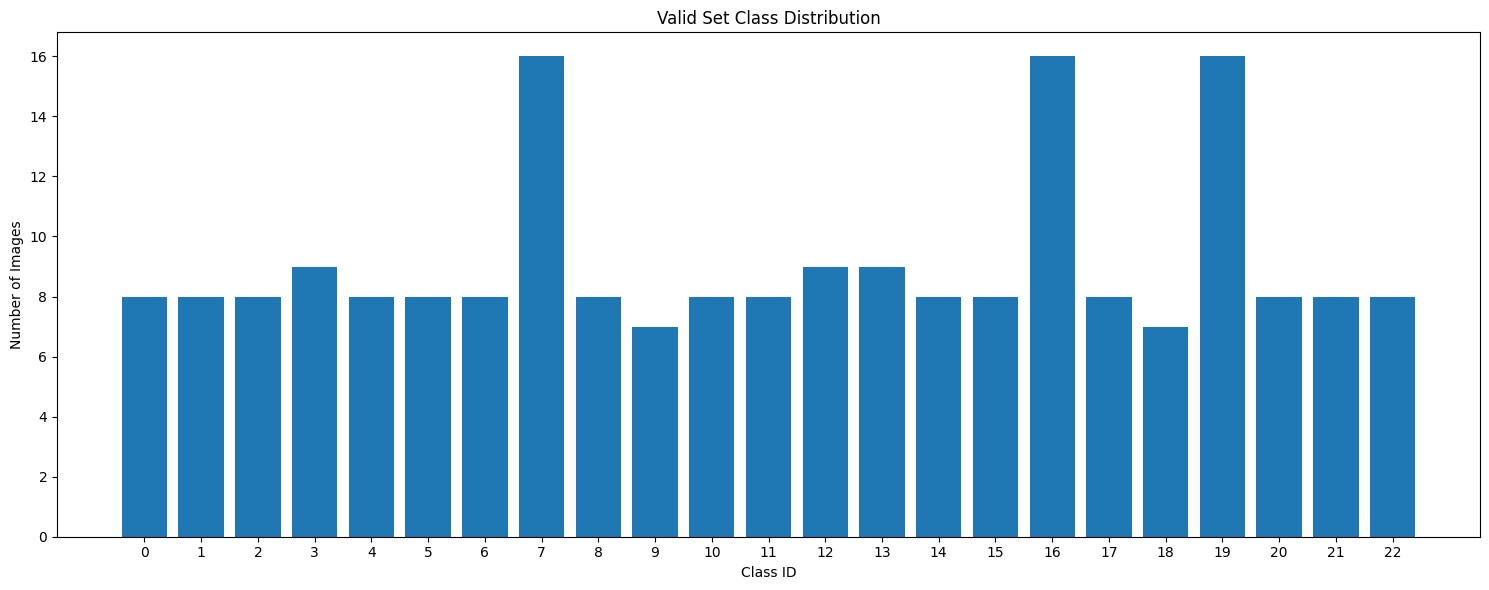


Valid Set Statistics:
Total images: 209
Class distribution: {14: 8, 2: 8, 7: 16, 9: 7, 10: 8, 19: 16, 16: 16, 11: 8, 13: 9, 12: 9, 0: 8, 3: 9, 22: 8, 6: 8, 18: 7, 20: 8, 8: 8, 21: 8, 15: 8, 5: 8, 1: 8, 4: 8, 17: 8}


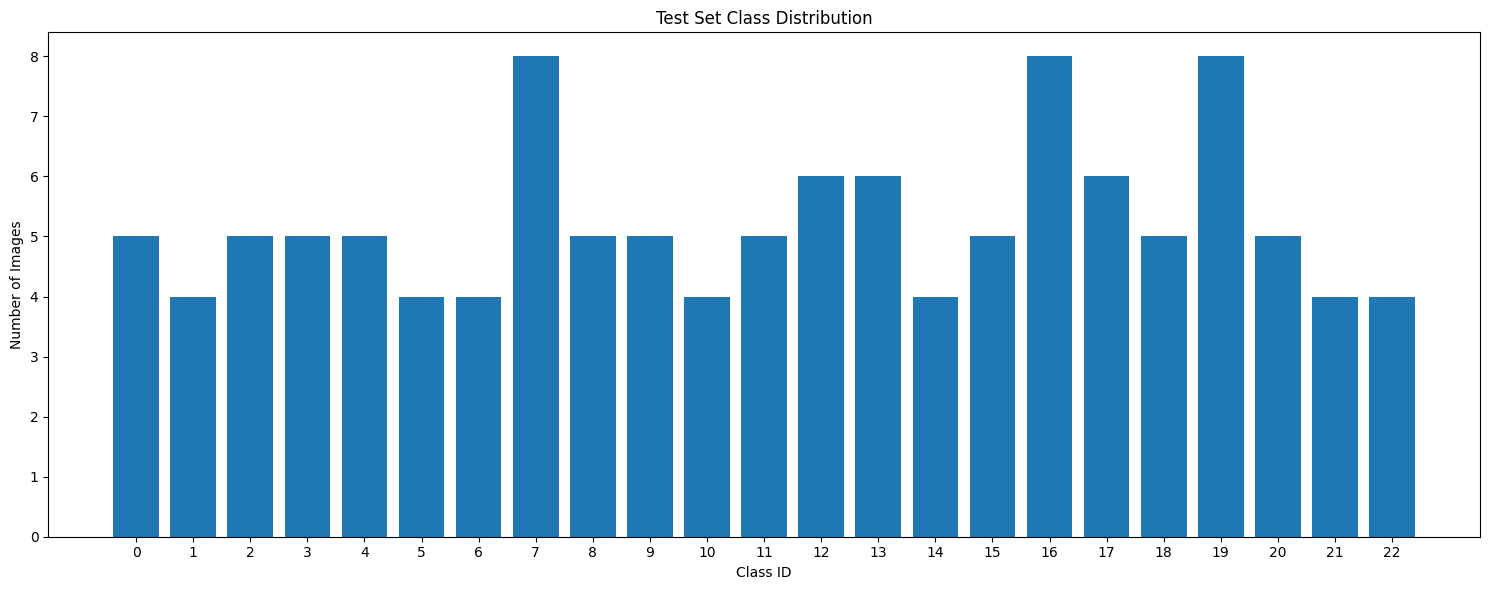


Test Set Statistics:
Total images: 120
Class distribution: {7: 8, 6: 4, 16: 8, 9: 5, 17: 6, 20: 5, 8: 5, 12: 6, 1: 4, 19: 8, 11: 5, 14: 4, 5: 4, 0: 5, 10: 4, 3: 5, 22: 4, 4: 5, 21: 4, 18: 5, 15: 5, 2: 5, 13: 6}


In [13]:
from sklearn.model_selection import train_test_split

def create_split_directories():
    base_dirs = ['train_split', 'valid_split', 'test_split']
    sub_dirs = ['images', 'labels']

    for base_dir in base_dirs:
        for sub_dir in sub_dirs:
            path = os.path.join(base_dir, sub_dir)
            if os.path.exists(path):
                shutil.rmtree(path)
            os.makedirs(path)

def get_class_distribution(label_dir):
    class_files = defaultdict(list)

    for label_file in os.listdir(label_dir):
        file_path = os.path.join(label_dir, label_file)
        with open(file_path, 'r') as f:
            label = int(f.readline().split()[0])
            class_files[label].append(label_file)

    return class_files

def balanced_split(class_files):
    train_files, valid_files, test_files = [], [], []

    for class_id, files in class_files.items():
        n_samples = len(files)
        n_train = int(0.7 * n_samples)
        n_valid = int(0.2 * n_samples)

        # 무작위 섞기
        np.random.shuffle(files)

        # 분할
        train_files.extend(files[:n_train])
        valid_files.extend(files[n_train:n_train+n_valid])
        test_files.extend(files[n_train+n_valid:])

    return train_files, valid_files, test_files

def copy_files_to_split(file_list, split_name):
    for file_name in file_list:
        # 라벨 파일 복사
        shutil.copy2(
            os.path.join('train/labels', file_name),
            os.path.join(f'{split_name}_split/labels', file_name)
        )

        # 이미지 파일 복사
        image_file = file_name.replace('.txt', '.jpg')
        shutil.copy2(
            os.path.join('train/images', image_file),
            os.path.join(f'{split_name}_split/images', image_file)
        )

def visualize_distribution(split_name):
    label_dir = os.path.join(f'{split_name}_split/labels')
    class_counts = Counter()

    for label_file in os.listdir(label_dir):
        with open(os.path.join(label_dir, label_file), 'r') as f:
            label = int(f.readline().split()[0])
            class_counts[label] += 1

    plt.figure(figsize=(15, 6))
    classes = sorted(class_counts.keys())
    counts = [class_counts[c] for c in classes]

    plt.bar(classes, counts)
    plt.title(f'{split_name.capitalize()} Set Class Distribution')
    plt.xlabel('Class ID')
    plt.ylabel('Number of Images')
    plt.xticks(classes)
    plt.tight_layout()
    plt.show()

    print(f"\n{split_name.capitalize()} Set Statistics:")
    print(f"Total images: {sum(counts)}")
    print("Class distribution:", dict(class_counts))

def main():
    # 디렉토리 생성
    create_split_directories()

    # 클래스별 파일 분포 확인
    class_files = get_class_distribution('train/labels')

    # 균형잡힌 분할 수행
    train_files, valid_files, test_files = balanced_split(class_files)

    # 파일 복사
    copy_files_to_split(train_files, 'train')
    copy_files_to_split(valid_files, 'valid')
    copy_files_to_split(test_files, 'test')

    # 분포 시각화
    for split_name in ['train', 'valid', 'test']:
        visualize_distribution(split_name)

if __name__ == "__main__":
    main()


---

In [14]:
import albumentations as A
import cv2

def create_augmentation():
    transform = A.Compose([
        # 이미지를 90도 단위로 무작위 회전
        A.RandomRotate90(p=0.5),

        # 이미지를 수평 또는 수직으로 뒤집기
        A.Flip(p=0.5),

        # 이미지의 행과 열을 교환 (전치)
        A.Transpose(p=0.5),

        # 노이즈 추가 (둘 중 하나 선택)
        A.OneOf([
            # A.IAAAdditiveGaussianNoise(),  # 가우시안 노이즈 추가
            A.GaussNoise(),                # 일반적인 가우시안 노이즈
        ], p=0.2),

        # 블러 효과 (셋 중 하나 선택)
        A.OneOf([
            A.MotionBlur(p=0.2),          # 움직임 효과의 블러
            A.MedianBlur(blur_limit=3, p=0.1),  # 중간값 필터를 이용한 블러
            A.Blur(blur_limit=3, p=0.1),        # 일반적인 블러
        ], p=0.2),

        # 이미지 왜곡 (둘 중 하나 선택)
        A.OneOf([
            A.OpticalDistortion(p=0.3),    # 광학 왜곡 효과
            A.GridDistortion(p=0.1),       # 격자 형태의 왜곡
        ], p=0.2),

        # 이미지 선명도와 대비 조정 (셋 중 하나 선택)
        A.OneOf([
           # A.IAASharpen(),               # 이미지 선명도 증가
           # A.IAAEmboss(),                # 엠보싱 효과
            A.RandomBrightnessContrast(), # 밝기와 대비 무작위 조정
        ], p=0.3),

        # 색조, 채도, 명도 조정
        # A.HueSaturationValue(p=0.3),
    ])
    return transform

    # 털색 때문에 조절
def augment_dataset(image_dir, label_dir, num_aug_per_image=2):
    transform = create_augmentation()

    # 이미지와 라벨 파일 목록
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    for img_file in image_files:
        # 이미지 로드
        image_path = os.path.join(image_dir, img_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 라벨 파일 경로
        label_file = img_file.replace('.jpg', '.txt')
        label_path = os.path.join(label_dir, label_file)

        for i in range(num_aug_per_image):
            # 데이터 증강 적용
            augmented = transform(image=image)
            aug_image = augmented['image']

            # 증강된 이미지 저장
            aug_filename = f"{os.path.splitext(img_file)[0]}_aug{i}.jpg"
            aug_image_path = os.path.join(image_dir, aug_filename)
            aug_image = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)
            cv2.imwrite(aug_image_path, aug_image)

            # 라벨 파일 복사
            aug_label_file = f"{os.path.splitext(img_file)[0]}_aug{i}.txt"
            aug_label_path = os.path.join(label_dir, aug_label_file)
            shutil.copy2(label_path, aug_label_path)

# 실행
image_dir = 'train_split/images'
label_dir = 'train_split/labels'
augment_dataset(image_dir, label_dir, num_aug_per_image=2)


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
<ipython-input-14-b752faaf3e9c>:10: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(p=0.5),


In [15]:
def count_images_by_class(label_dir):
    # 클래스별 이미지 카운트
    class_counts = Counter()

    # 라벨 파일 읽기
    for label_file in os.listdir(label_dir):
        with open(os.path.join(label_dir, label_file), 'r') as f:
            label = int(f.readline().split()[0])
            class_counts[label] += 1

    # 전체 이미지 수
    total_images = sum(class_counts.values())

    print(f"전체 이미지 수: {total_images}")
    print("\n클래스별 이미지 수:")
    for class_id, count in sorted(class_counts.items()):
        print(f"Class {class_id}: {count} images")

    return class_counts

# 실행
label_dir = 'train_split/labels'
class_counts = count_images_by_class(label_dir)

전체 이미지 수: 2226

클래스별 이미지 수:
Class 0: 84 images
Class 1: 84 images
Class 2: 87 images
Class 3: 93 images
Class 4: 87 images
Class 5: 84 images
Class 6: 84 images
Class 7: 168 images
Class 8: 90 images
Class 9: 78 images
Class 10: 84 images
Class 11: 87 images
Class 12: 96 images
Class 13: 96 images
Class 14: 84 images
Class 15: 84 images
Class 16: 168 images
Class 17: 90 images
Class 18: 78 images
Class 19: 168 images
Class 20: 84 images
Class 21: 84 images
Class 22: 84 images


In [16]:
def plot_random_images(image_dir, num_images=20, seed=1):
    # 시드 고정
    random.seed(seed)
    np.random.seed(seed)

    # 이미지 파일 목록
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]

    # 랜덤 선택
    selected_files = random.sample(image_files, min(num_images, len(image_files)))

    # 플롯 설정
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    fig.suptitle('Random Sample of Augmented Images', fontsize=16)

    for idx, img_file in enumerate(selected_files):
        # 이미지 로드
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 서브플롯에 이미지 표시
        row = idx // 5
        col = idx % 5
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(f'Image {idx+1}', fontsize=8)

    plt.tight_layout()
    plt.show()

# 실행
image_dir = 'train_split/images'
plot_random_images(image_dir, num_images=20, seed=42)


Output hidden; open in https://colab.research.google.com to view.

---

In [17]:
project = "./runs/detect"
name = "train_split"

dataset_path = "/content/data.yaml"

In [18]:
torch.cuda.empty_cache()

In [19]:
# YAML 파일 읽기
with open('data.yaml', 'r', encoding='utf-8') as file:
    data = yaml.safe_load(file)

# 경로 수정
data['train'] = '../train_split/images'
data['val'] = '../valid_split/images'
data['test'] = '../test_split/images'

# 수정된 YAML 파일 저장
with open('data.yaml', 'w', encoding='utf-8') as file:
    yaml.dump(data, file, allow_unicode=True, sort_keys=False)


In [20]:
model.train(
    data=dataset_path, # 데이터셋 경로(yaml파일)
    epochs=100, # 최대 학습 epoch
    project=project, # project 폴더 이름
    name=name, # experiment 폴더 이름
    exist_ok=False, # 덮어쓰기 여부
    seed=42, # 재현성을 위한 시드 설정
    optimizer='AdamW', # optimizer는 AdamW로 지정
    patience=5, # 30epoch동안 loss가 개선되지 않으면 종료
    batch=32, # 훈련 배치 사이즈는 32
    imgsz=640, # 이미지 사이즈는 640
)

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/data.yaml, epochs=100, time=None, patience=5, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=./runs/detect, name=train_split, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

100%|██████████| 755k/755k [00:00<00:00, 21.2MB/s]


Overriding model.yaml nc=80 with nc=23

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 107MB/s]


AMP: checks passed ✅


train: Scanning /content/train_split/labels... 2226 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2226/2226 [00:01<00:00, 1863.40it/s]


train: New cache created: /content/train_split/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/valid_split/labels... 209 images, 0 backgrounds, 0 corrupt: 100%|██████████| 209/209 [00:00<00:00, 822.26it/s]

val: New cache created: /content/valid_split/labels.cache


Plotting labels to runs/detect/train_split/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train_split
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.66G       1.63      3.741      2.042         48        640: 100%|██████████| 70/70 [00:52<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]

                   all        209        229          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      8.62G      1.663      3.279      2.036         43        640: 100%|██████████| 70/70 [00:48<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

                   all        209        229   8.55e-06    0.00242   4.86e-06   4.86e-07



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.64G      1.625      3.154      2.002         43        640: 100%|██████████| 70/70 [00:48<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


                   all        209        229   2.91e-05    0.00395   1.58e-05   1.97e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.64G      1.616      3.109      1.984         49        640: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


                   all        209        229      0.045      0.103    0.00187   0.000532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      8.64G      1.574      3.027      1.946         47        640: 100%|██████████| 70/70 [00:49<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all        209        229    0.00264      0.655    0.00775    0.00323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.67G      1.596      3.049      1.963         53        640: 100%|██████████| 70/70 [00:47<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        209        229    0.00353      0.838     0.0391      0.015



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.64G      1.559      3.001      1.929         47        640: 100%|██████████| 70/70 [00:49<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]

                   all        209        229      0.203     0.0976     0.0302    0.00999



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      8.64G      1.563      3.003      1.923         47        640: 100%|██████████| 70/70 [00:51<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


                   all        209        229      0.488      0.139     0.0545     0.0246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.65G      1.517      2.954      1.896         51        640: 100%|██████████| 70/70 [00:49<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all        209        229     0.0235      0.792     0.0668     0.0282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.64G      1.513      2.927      1.893         49        640: 100%|██████████| 70/70 [00:49<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

                   all        209        229    0.00705       0.91     0.0538     0.0245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.64G      1.504      2.937      1.885         57        640: 100%|██████████| 70/70 [00:50<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        209        229     0.0352      0.742     0.0693     0.0327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      8.64G       1.48       2.89      1.858         44        640: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        209        229     0.0127      0.654      0.046     0.0176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.64G      1.473      2.853      1.859         53        640: 100%|██████████| 70/70 [00:48<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

                   all        209        229      0.184      0.323     0.0838     0.0424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.64G      1.471      2.841      1.863         54        640: 100%|██████████| 70/70 [00:49<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

                   all        209        229      0.213      0.264     0.0726     0.0326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      8.65G      1.462      2.835      1.852         55        640: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


                   all        209        229      0.399      0.158     0.0799     0.0415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      8.64G      1.453      2.807       1.84         50        640: 100%|██████████| 70/70 [00:48<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

                   all        209        229      0.465      0.159     0.0877     0.0391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      8.64G      1.451      2.832      1.842         69        640: 100%|██████████| 70/70 [00:47<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]

                   all        209        229      0.284       0.33      0.104     0.0556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.65G      1.438      2.774      1.833         41        640: 100%|██████████| 70/70 [00:50<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]

                   all        209        229      0.359      0.217     0.0953     0.0453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.68G      1.425      2.777      1.827         47        640: 100%|██████████| 70/70 [00:49<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all        209        229      0.361      0.241        0.1     0.0517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.64G      1.417      2.756      1.818         45        640: 100%|██████████| 70/70 [00:47<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        209        229      0.508      0.122      0.108     0.0567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      8.63G      1.392       2.74      1.801         50        640: 100%|██████████| 70/70 [00:49<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]

                   all        209        229      0.267      0.215     0.0953     0.0512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      8.64G        1.4      2.709        1.8         53        640: 100%|██████████| 70/70 [00:52<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


                   all        209        229      0.257       0.32      0.121     0.0611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      8.65G      1.389      2.709      1.786         57        640: 100%|██████████| 70/70 [00:48<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all        209        229      0.597      0.113     0.0928     0.0485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.64G      1.393      2.693        1.8         52        640: 100%|██████████| 70/70 [00:48<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

                   all        209        229      0.233      0.231       0.12     0.0664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.64G      1.375      2.696      1.789         55        640: 100%|██████████| 70/70 [00:49<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]

                   all        209        229      0.325      0.329      0.111     0.0591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      8.64G      1.388       2.68      1.787         42        640: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]


                   all        209        229      0.539      0.274      0.126     0.0618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.64G      1.376      2.667      1.785         53        640: 100%|██████████| 70/70 [00:46<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        209        229      0.247       0.37      0.141     0.0787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.64G      1.363      2.644      1.776         59        640: 100%|██████████| 70/70 [00:46<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        209        229      0.147      0.352      0.159     0.0824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      8.64G      1.369      2.642      1.771         51        640: 100%|██████████| 70/70 [00:50<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

                   all        209        229       0.21      0.314      0.153     0.0838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.64G      1.355      2.603      1.767         62        640: 100%|██████████| 70/70 [00:48<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        209        229      0.356      0.301      0.142     0.0778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      8.64G      1.371      2.606      1.775         52        640: 100%|██████████| 70/70 [00:47<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all        209        229      0.168      0.337       0.14      0.082



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      8.64G      1.343       2.58      1.753         55        640: 100%|██████████| 70/70 [00:49<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

                   all        209        229      0.103      0.357      0.162     0.0836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      8.64G      1.348      2.579      1.745         52        640: 100%|██████████| 70/70 [00:50<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        209        229      0.296      0.333      0.154     0.0942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.64G       1.33      2.539      1.745         57        640: 100%|██████████| 70/70 [00:47<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all        209        229      0.147      0.383      0.167      0.088



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.64G      1.344      2.569      1.756         59        640: 100%|██████████| 70/70 [00:47<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        209        229       0.29      0.252      0.122      0.071



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.64G      1.341      2.571      1.756         52        640: 100%|██████████| 70/70 [00:50<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


                   all        209        229      0.292      0.297      0.178     0.0961

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.64G      1.339      2.527      1.752         59        640: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        209        229       0.24      0.239      0.116     0.0632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      8.64G      1.325      2.527      1.737         61        640: 100%|██████████| 70/70 [00:48<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        209        229      0.207      0.387      0.171     0.0942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      8.64G      1.319      2.526       1.74         61        640: 100%|██████████| 70/70 [00:48<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


                   all        209        229      0.127      0.424      0.188      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.64G      1.307      2.525       1.74         47        640: 100%|██████████| 70/70 [00:51<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        209        229      0.299      0.372       0.15     0.0796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.64G      1.311      2.502      1.733         42        640: 100%|██████████| 70/70 [00:50<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        209        229      0.236      0.253       0.15     0.0779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.64G      1.304      2.499      1.733         48        640: 100%|██████████| 70/70 [00:48<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        209        229      0.175      0.362      0.169     0.0899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.64G      1.292       2.51      1.719         58        640: 100%|██████████| 70/70 [00:48<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]

                   all        209        229      0.227      0.378      0.201      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      8.65G      1.316      2.468      1.734         46        640: 100%|██████████| 70/70 [00:50<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

                   all        209        229        0.2       0.35       0.22      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      8.64G      1.315      2.461       1.73         58        640: 100%|██████████| 70/70 [00:49<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

                   all        209        229      0.164      0.393      0.204      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      8.64G      1.298      2.446      1.712         56        640: 100%|██████████| 70/70 [00:49<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]

                   all        209        229      0.176      0.416      0.188      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.64G      1.298      2.457      1.708         50        640: 100%|██████████| 70/70 [00:47<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]

                   all        209        229       0.14       0.17     0.0959     0.0577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.64G      1.275      2.424        1.7         51        640: 100%|██████████| 70/70 [00:48<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        209        229      0.257      0.355      0.185      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.64G      1.282      2.446       1.71         53        640: 100%|██████████| 70/70 [00:49<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

                   all        209        229      0.302      0.342      0.163     0.0866


EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 44, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

49 epochs completed in 0.732 hours.
Optimizer stripped from runs/detect/train_split/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/train_split/weights/best.pt, 19.2MB

Validating runs/detect/train_split/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,421,701 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


                   all        209        229        0.2       0.35      0.221      0.132
            Abyssinian          8          9      0.281     0.0937      0.165      0.103
                Bengal          8          8       0.21      0.625      0.466      0.189
                Birman          8          8     0.0738      0.125      0.136     0.0887
                Bombay          9         10      0.237        0.8      0.585      0.302
          British Long          8         11        0.3      0.182      0.223      0.171
         British short          8          9      0.284      0.444      0.366      0.229
               Burmese          8          9      0.071      0.111      0.117     0.0594
              Domestic         16         17     0.0602      0.294      0.147      0.104
          Egyption Mau          8         11      0.175      0.364      0.346      0.257
      Exotic Shorthair          7          7          0          0     0.0808     0.0405
            Maine Coo

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ce31ec63e50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.0420

In [21]:
print(type(model.names), len(model.names))
print(model.names)

<class 'dict'> 23
{0: 'Abyssinian', 1: 'Bengal', 2: 'Birman', 3: 'Bombay', 4: 'British Long', 5: 'British short', 6: 'Burmese', 7: 'Domestic', 8: 'Egyption Mau', 9: 'Exotic Shorthair', 10: 'Maine Coon', 11: 'Munckin', 12: 'Norwegian Forest', 13: 'Oriental', 14: 'Persian', 15: 'Ragdoll', 16: 'Rex Type', 17: 'Russian Blue', 18: 'Scottish Fold', 19: 'Siamese Type', 20: 'Siberian', 21: 'Sphynx', 22: 'Turkish Angora'}


학습 시 Loss 및 성능 지표 변화 시각화

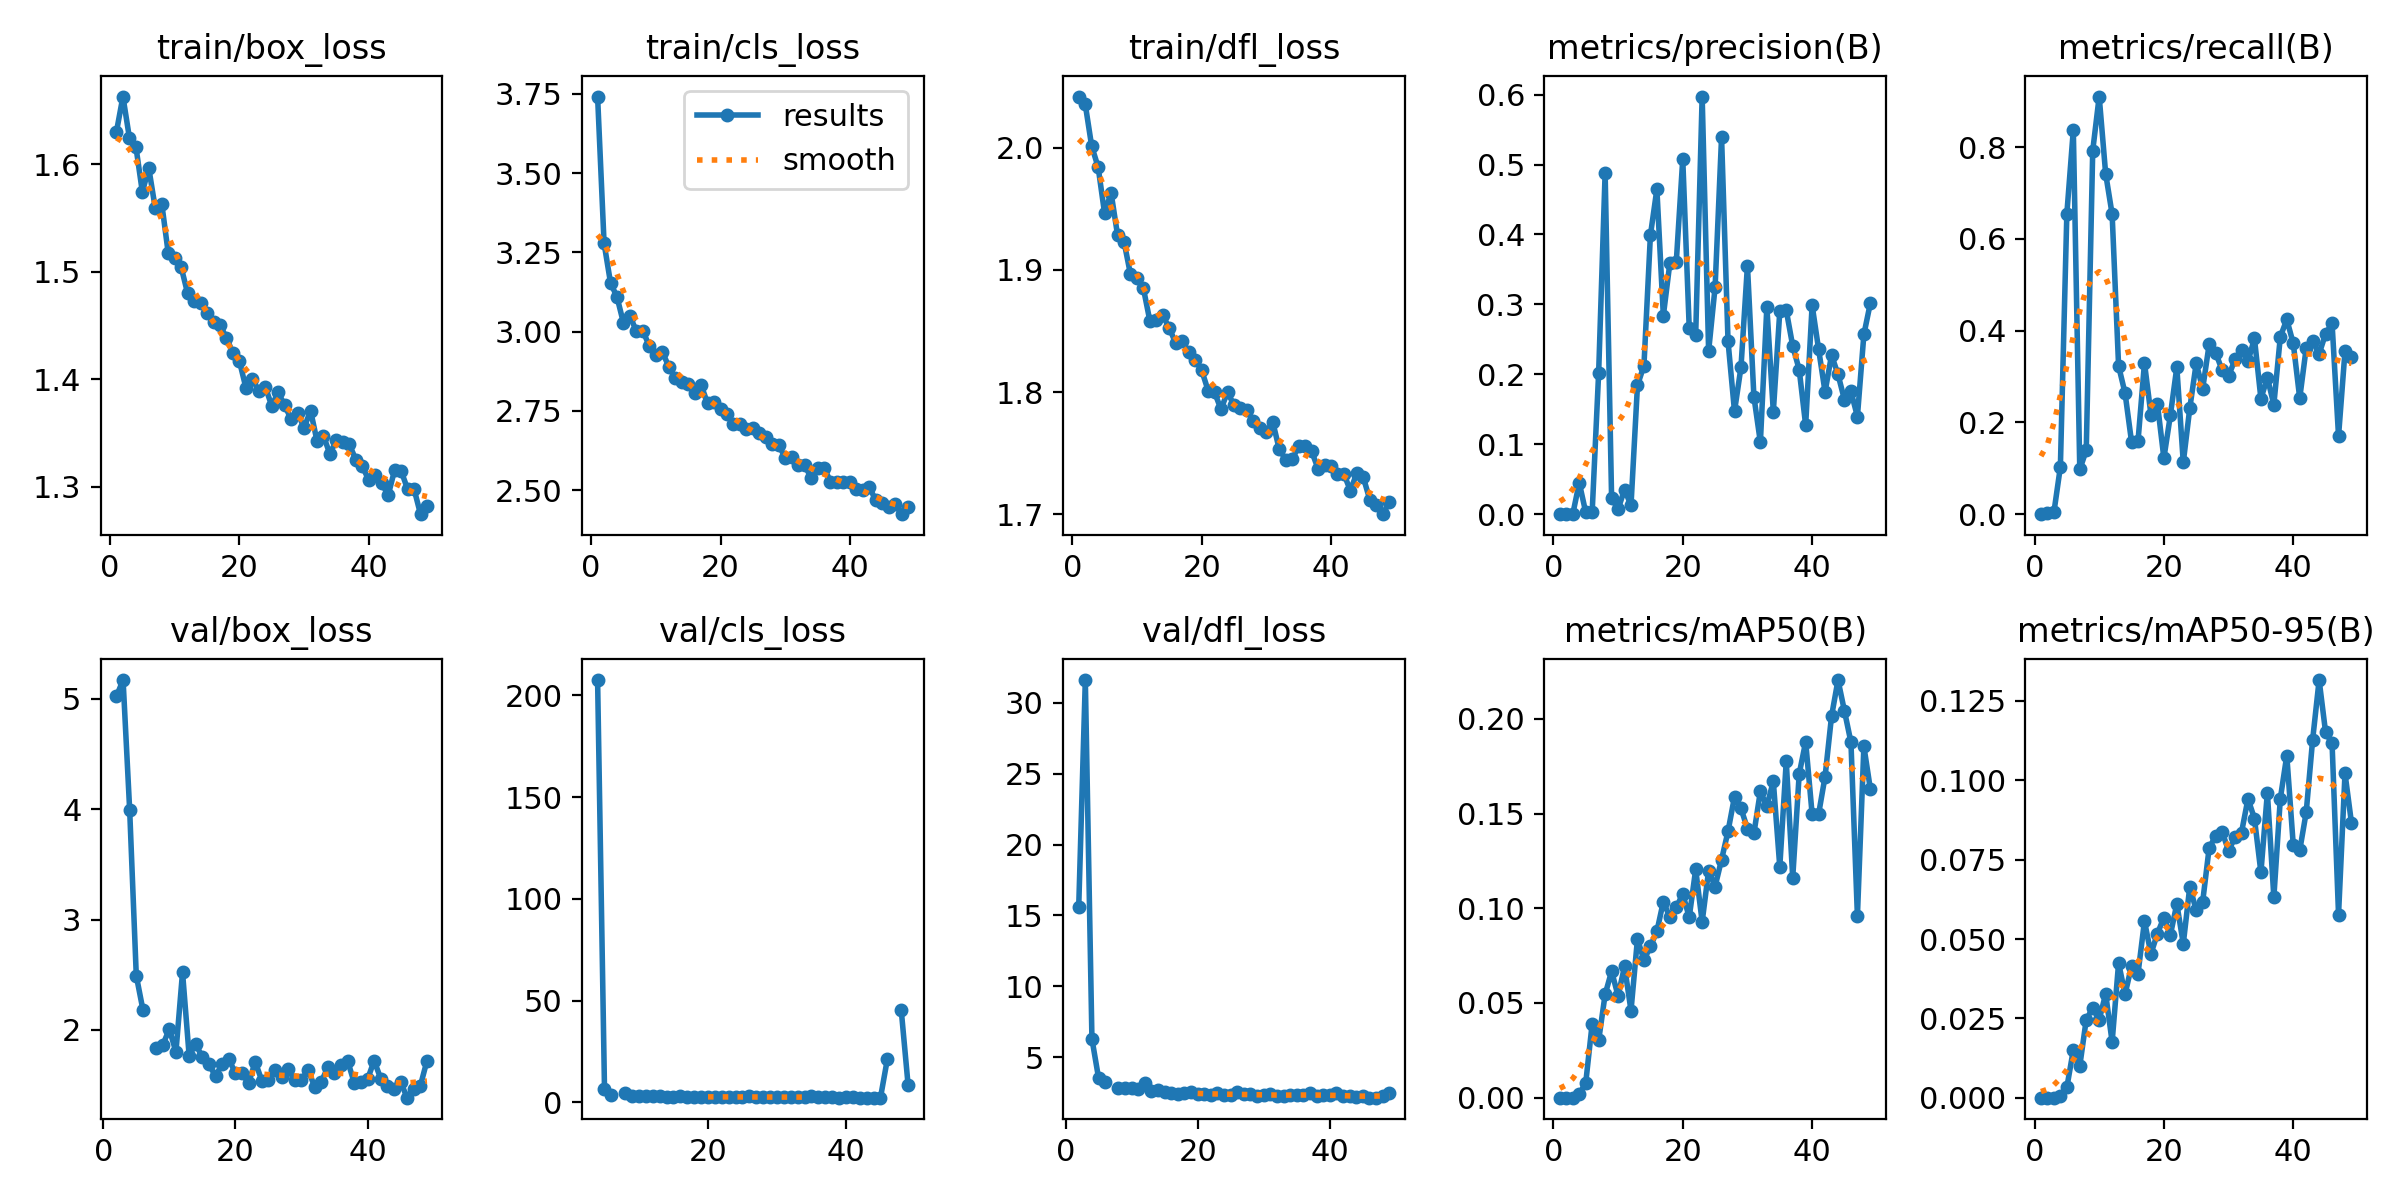

In [23]:
results_png_path = f"/content/runs/detect/train_split/results.png"  # Construct the expected path
show_image(results_png_path, width=1600)

In [24]:
model = YOLO(f"{project}/{name}/weights/best.pt")
print(type(model.names), len(model.names))
print(model.names)

<class 'dict'> 23
{0: 'Abyssinian', 1: 'Bengal', 2: 'Birman', 3: 'Bombay', 4: 'British Long', 5: 'British short', 6: 'Burmese', 7: 'Domestic', 8: 'Egyption Mau', 9: 'Exotic Shorthair', 10: 'Maine Coon', 11: 'Munckin', 12: 'Norwegian Forest', 13: 'Oriental', 14: 'Persian', 15: 'Ragdoll', 16: 'Rex Type', 17: 'Russian Blue', 18: 'Scottish Fold', 19: 'Siamese Type', 20: 'Siberian', 21: 'Sphynx', 22: 'Turkish Angora'}


In [25]:
test_name = "test_result" # 테스트 결과를 저장할 폴더 이름 설정
test_result = model.val(imgsz=640, split="test", name=test_name) # 테스트 데이터셋 평가 실행

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,421,701 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning /content/test_split/labels... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<00:00, 357.39it/s]

val: New cache created: /content/test_split/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


                   all        120        126      0.122      0.353      0.202      0.121
            Abyssinian          5          5      0.351        0.4      0.225      0.149
                Bengal          4          4      0.256        0.5      0.364      0.252
                Birman          5          6          0          0     0.0673      0.035
                Bombay          5          5      0.205        0.8      0.511      0.425
          British Long          5          5      0.251        0.4      0.385      0.193
         British short          4          5          0          0     0.0709     0.0408
               Burmese          4          6          0          0     0.0407     0.0235
              Domestic          8          8      0.137       0.75      0.232      0.196
          Egyption Mau          5          5      0.142        0.4      0.367      0.107
      Exotic Shorthair          5          5          0          0     0.0905     0.0523
            Maine Coo

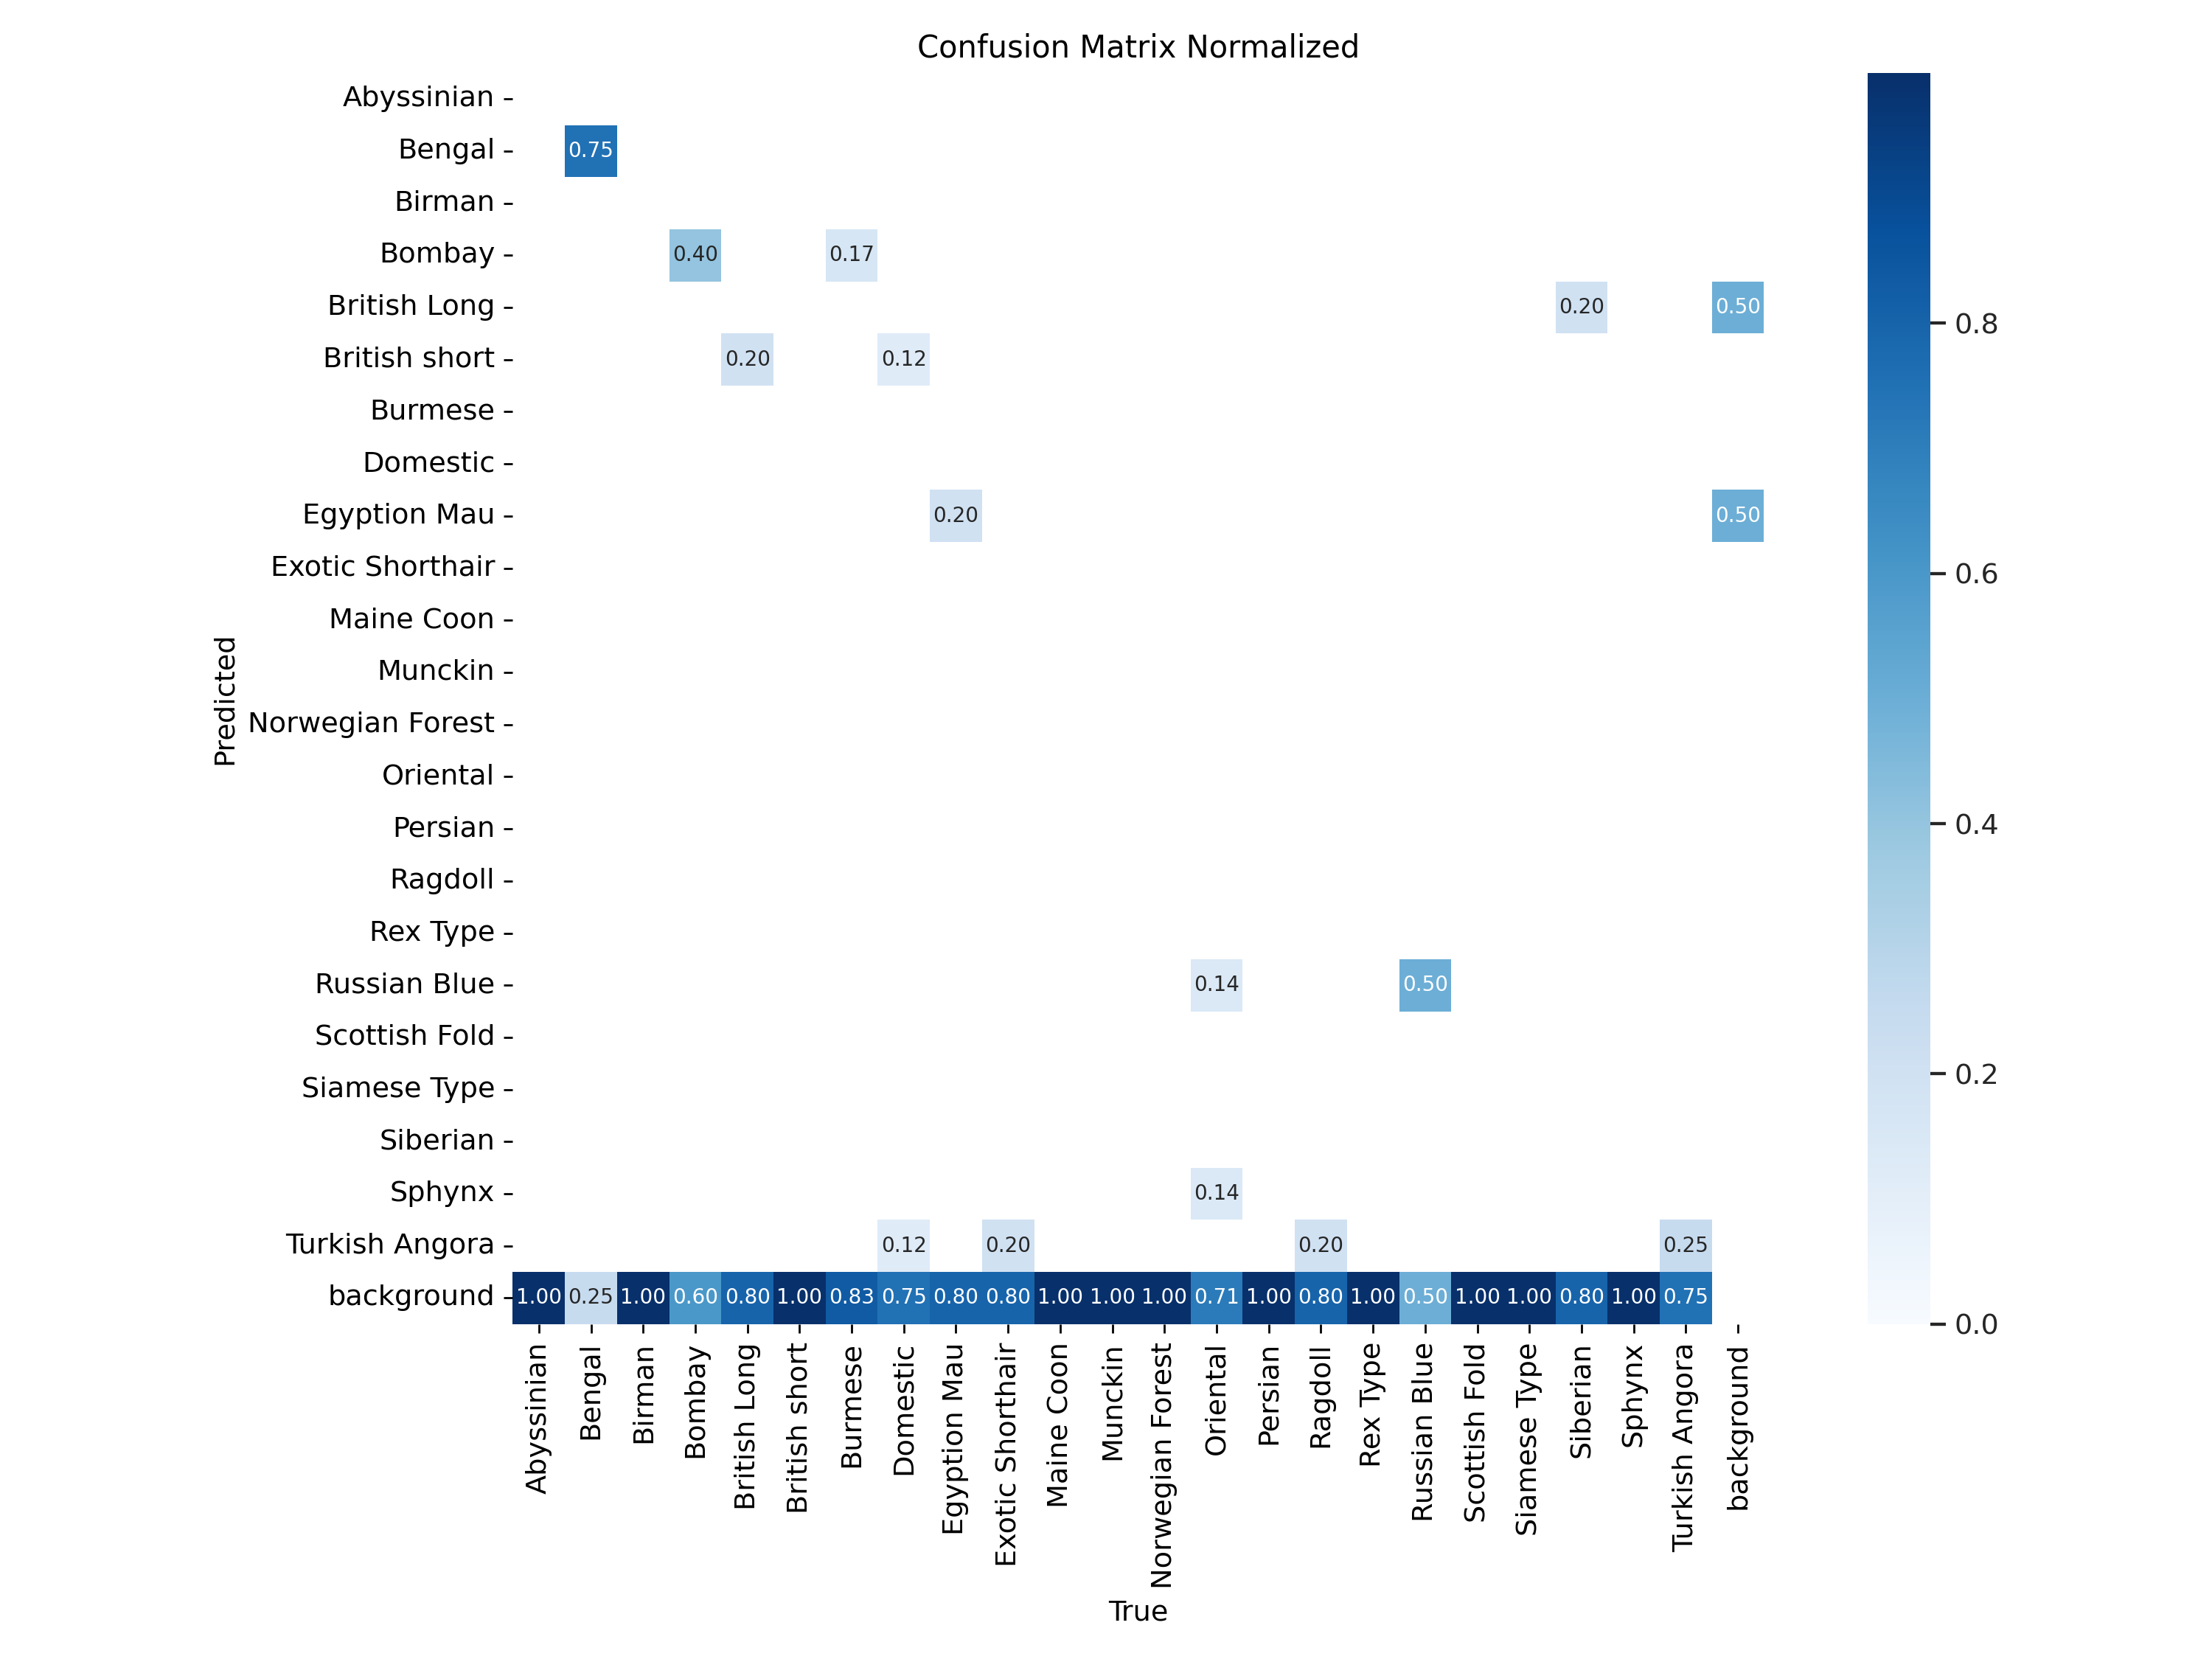

In [26]:
# 테스트 데이터셋 결과를 혼동 행렬 이미지로 시각화
show_image(f"runs/detect/test_result/confusion_matrix_normalized.png", width=800, height=800)

In [27]:
test_inference_name = "test_predict"
image_paths = glob.glob('/content/test/images/*jpg')
# 설정한 배치 크기
batch_size = 4

# 이미지 경로를 배치 크기에 맞춰 분할
test_inference_results = []
for i in tqdm(range(0, len(image_paths), batch_size)):
    batch_paths = image_paths[i:i + batch_size]
    results = model.predict(project=project,
                            source=batch_paths,
                            name=test_inference_name,
                            device='cuda',
                            imgsz=640, save=True,
                            save_txt=True,
                            save_conf=True,
                            show_conf=False,
                            exist_ok=True)

    # 최신 버전에서는 이 줄 제거
    # for item in results:
    #     del item.orig_img
    test_inference_results.append(results)

# 배치사이즈 만큼 묶여 있는 리스트를 풀어줌
test_inference_results = sum(test_inference_results,[])

# 추론 결과 저장
import pickle
import os

# 저장 디렉토리 생성 (없다면)
os.makedirs('./inference_results', exist_ok=True)

# 추론 결과 저장
with open('./inference_results/test_inference_results.pkl', 'wb') as f:
    pickle.dump(test_inference_results, f)

# 저장 확인용 메시지
print(f"Inference results saved. Total results: {len(test_inference_results)}")

0it [00:00, ?it/s]

Inference results saved. Total results: 0


In [28]:
map50_95 = test_result.results_dict['metrics/mAP50-95(B)']
map50 = test_result.results_dict['metrics/mAP50(B)']

print(f"mAP50-95: {map50_95}")
print(f"mAP50: {map50}")

mAP50-95: 0.12132819437646115
mAP50: 0.20160848847728505


In [29]:
# labels 폴더 아래의 모든 txt 파일 경로 가져오기
txt_files = glob.glob('/content/test/labels/*.txt')

# DataFrame을 저장할 리스트 생성
data = []

# 각 txt 파일을 읽어서 DataFrame에 추가
for txt_file in txt_files:
    with open(txt_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 2:  # class id와 bounding box 정보가 있는지 확인
                class_id = int(parts[0])
                bbox = [float(x) for x in parts[1:]]
                image_name = os.path.splitext(os.path.basename(txt_file))[0] + ".jpg"  # 이미지 파일 이름 추출 (.txt를 .jpg로 변경)
                data.append([image_name, class_id, bbox])


# DataFrame 생성
labels_df = pd.DataFrame(data, columns=['image_name', 'class_id', 'bbox'])

# class id를 label 이름으로 변환 (model.names를 사용)
labels_df['label'] = labels_df['class_id'].map(lambda x: model.names[x])

# image_name을 index로 설정
labels_df = labels_df.set_index('image_name')

print(labels_df.head())

Empty DataFrame
Columns: [class_id, bbox, label]
Index: []


In [ ]:
import os
from collections import Counter
from pathlib import Path
import re

def extract_base_names(folder_path):
    # 이미지 파일 확장자
    image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp')

    # 파일 이름 리스트 생성
    base_names = []
    for file in Path(folder_path).rglob('*'):
        if file.suffix.lower() in image_extensions:
            # 영문자만 추출 (숫자와 특수문자 이전까지)
            base_name = re.match(r'^[a-zA-Z]+', file.stem)
            if base_name:
                base_names.append(base_name.group())

    # 빈도수 계산
    name_counts = Counter(base_names)

    # 결과 출력
    print("\n파일 이름 빈도수:")
    print("-" * 30)
    for name, count in name_counts.most_common():
        print(f"{name}: {count}개")
    print("-" * 30)
    print(f"총 고유 파일 이름 수: {len(name_counts)}개")
    print(f"총 이미지 파일 수: {len(base_names)}개")

# 실행
folder_path = "test"
extract_base_names(folder_path)

In [31]:
from google.colab import files
import shutil

shutil.make_archive("runs", 'zip', "/content/runs")
files.download("runs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>